In [3]:
import pandas as pd
import random
close = pd.read_parquet("../../db/tw/Adj_close.parquet")
close.index = pd.to_datetime(close.index)
stock_list_total = list(close.columns)
random_num = [random.randint(0, len(stock_list_total)) for _ in range(100)]
stock_list = [stock_list_total[i] for i in random_num]
stock_list = stock_list_total[-100:]

In [26]:
import yfinance as yf
import statsmodels.api as sm
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import pacf
warnings.filterwarnings("ignore")
resample_map = {
    "weekly": "W",
    "biweekly": "2W",
    "monthly": "M"
}

# params
train_end_str = "2019-01-01"
train_end = pd.to_datetime(train_end_str)
train_start = train_end - timedelta(days=365)

close = close.loc[train_start:pd.to_datetime("2024-01-01")][close.columns.intersection(stock_list)]
pct_change = close.pct_change().dropna(how='all', axis=0)
pct_change = pct_change.resample(resample_map['monthly']).sum()

In [11]:
modeling_end = "2020-01-01"
starter_index = np.where(pct_change.index < pd.to_datetime(modeling_end))[0][-1]
factors = []
indices = []
print(starter_index)

23


In [ ]:

for index in range(len(pct_change)-starter_index+1):

    # rolling calculating time series
    pct_change_train = pct_change.iloc[index:starter_index+index]
    print(pct_change_train.index[0], pct_change_train.index[-1])
    prediction_factor = []
    for ticker in list(pct_change_train.columns):
        # get max lags with pacf
        pacf_values = pacf(pct_change_train[ticker], method='ywm')
        
        N = len(pct_change_train[ticker])
        threshold = 1.96 / np.sqrt(N)

        significant_indices = np.where(np.abs(pacf_values) > threshold)[0]
        significant_pacf_values = pacf_values[significant_indices]
        if len(significant_indices) >= 2:
            best_lag_n = significant_indices[1]
        elif len(significant_indices) == 1:
            best_lag_n = np.argmax(np.abs(pacf_values[1:])) + 1

        # get predictions(upward/downward)
        train_data = pct_change_train[ticker]
        model = sm.tsa.arima.ARIMA(train_data, order=(best_lag_n, 0, 0)) # order = (ar_t, i_t, ma_t), for ar model only => ma_t = 0
        model_fit = model.fit()
        prediction = model_fit.forecast()
        # print(ticker, prediction[0], prediction.index[0])
        prediction_factor.append(prediction[0])
        # print(ticker, prediction[0])
    factors.append(prediction_factor)
    indices.append(pct_change_train.index[-1])

In [15]:
tester = pd.DataFrame(factors, columns=list(pct_change_train.columns), index=indices)
tester.to_csv("../data/ARIMA_freqM_last100_2020.csv")

In [39]:
df1 = tester.dropna(axis='columns', how='all').copy()
demean = df1.sub(df1.mean(axis=1), axis=0)
weighting = demean.div(demean.abs().sum(axis=1), axis=0)

In [40]:
close_prices_df = close
close_prices_df.dropna(how='any', axis=1, inplace=True)
close_prices_df_m = close_prices_df.resample('M').mean()
pct_change_df_m = close_prices_df_m.pct_change().shift(-1)

Maximum Drawdown (MDD): -29.62%
Sharpe Ratio: 1.5919714595095662
CAGR: 16.12%
Karma Ratio: 2.5601151369867856


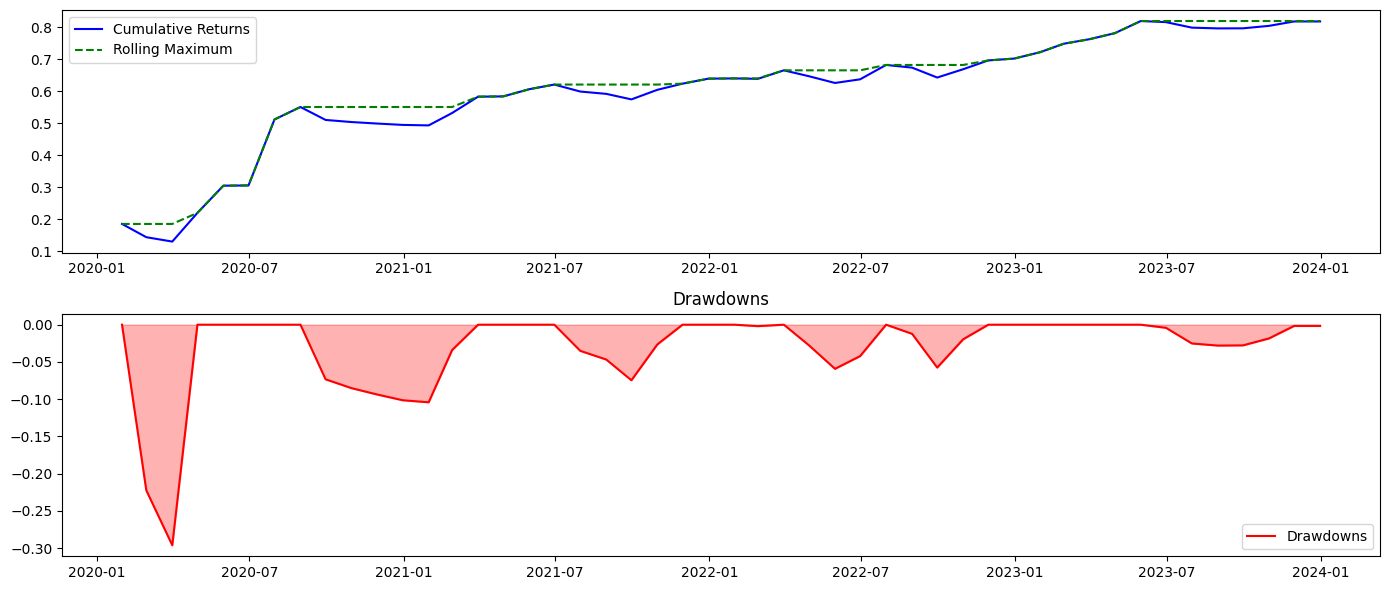

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
fee = 0.01
portfolio_returns = (weighting[weighting > 0].fillna(0) * pct_change_df_m).sum(axis=1)
portfolio_returns = portfolio_returns[portfolio_returns.index >= modeling_end]
# Plot returns
returns_series = (1 + portfolio_returns).cumprod()*(1-fee)
returns_series = portfolio_returns.cumsum()

# Calculate performance metrics
def sharpe_ratio(returns, risk_free_rate=0.03):
    excess_return = ((1 + returns).cumprod()*(1-fee)) - risk_free_rate
    return  (np.mean(excess_return)/ np.std(excess_return))**(1/4)
def karma_ratio(returns):
    positive_returns = returns[returns > 0]
    negative_returns = returns[returns < 0]

    if len(negative_returns) == 0:
        karma_ratio = np.mean(positive_returns) / 0.00001  # Avoid division by zero
    else:
        karma_ratio = np.mean(positive_returns) / np.abs(np.mean(negative_returns))

    return karma_ratio

cumulative_returns = returns_series
rolling_max = cumulative_returns.cummax()
drawdowns = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdowns.min()

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(cumulative_returns, label='Cumulative Returns', color='blue')
plt.plot(rolling_max, label='Rolling Maximum', color='green', linestyle='--')
plt.legend()

# Plot drawdowns
plt.subplot(2, 1, 2)
plt.plot(drawdowns, label='Drawdowns', color='red')
plt.fill_between(drawdowns.index, drawdowns, color='red', alpha=0.3)
plt.title('Drawdowns')
plt.legend()

plt.tight_layout()

print("Maximum Drawdown (MDD): {:.2%}".format(max_drawdown))
print("Sharpe Ratio:", sharpe_ratio(portfolio_returns))
print(f"CAGR: {np.round(((1 + returns_series[-1])**(1/4) - 1)*100, 2)}%")
print("Karma Ratio:", karma_ratio(portfolio_returns))

plt.show()
